In [5]:
# This is a variational implementation of the hierarchical_2pl model from the Stan examples.

import VariationalBayes as vb
from VariationalBayes.SparseObjectives import Objective
import VariationalBayes.ExponentialFamilies as ef
import VariationalBayes.Modeling as modeling
import hierarchical_2pl_lib as hier_model

import math

import autograd
import autograd.numpy as np
import numpy as onp

import matplotlib.pyplot as plt
%matplotlib inline

import time

from copy import deepcopy
import scipy as sp
from scipy import optimize
from scipy import stats


import pystan 

In [10]:
import pandas as pd
import os
import json

simulate_data = True

if simulate_data:
    np.random.seed(42)
    num_i = 30
    num_j = 2000
    true_params, y, y_prob = hier_model.simulate_data(num_i=num_i, num_j=num_j)
    prior_params = hier_model.get_prior_params()

else:
    # This json file is generated by the script hierarchical_base_mcmc.R in StanSensitivity.
    data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                            'StanSensitivity/examples/example_models/hierarchical_2pl/')
    json_filename = os.path.join(data_dir, 'hierarchical_2pl_mcmc_results.json')

    json_file = open(json_filename, 'r')
    json_dat = json.load(json_file)
    json_file.close()

    mcmc_df = pd.DataFrame({ 'mean': json_dat['mcmc_results']['mean'],
                             'se_mean': json_dat['mcmc_results']['se_mean'],
                             'sd': json_dat['mcmc_results']['sd'],
                             'par': json_dat['mcmc_results']['pars'],  })
    stan_data = json_dat['stan_data']

    num_i = stan_data['I'][0]
    num_j = stan_data['J'][0]
    y = np.reshape(np.array(stan_data['y']), (num_i, num_j))
    # print(y[0:5, 0:5]) # Checked by hand that this is the transpose of the R matrix

    # Set the prior parameters.
    prior_params = hier_model.get_prior_params()

    prior_params['lkj_param'].set(stan_data['lkj_concentration'][0])
    prior_params['theta_mean'].set(stan_data['theta_loc'][0])
    prior_params['theta_var'].set(stan_data['theta_scale'][0] ** 2) 

    s11 = stan_data['mu_1_scale'][0]
    s22 = stan_data['mu_2_scale'][0]
    mu_cov = np.array([[s11 ** 2, 0.], [0., s22 ** 2]])
    prior_params['mu_info'].set(np.linalg.inv(mu_cov))

    tau_param = np.full(2, stan_data['tau_loc'][0])
    prior_params['tau_param'].set(tau_param)

    mu_loc = np.full(2, stan_data['mu_loc'][0])
    prior_params['mu_mean'].set(mu_loc)

print('num_i: ', num_i)
print('num_j: ', num_j)

num_i:  32
num_j:  600


In [61]:
data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'StanSensitivity/examples/example_models/hierarchical_2pl/')
sm = pystan.StanModel(file=os.path.join(data_dir, 'hierarchical_2pl_generated.stan'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_73866b16a924caaf7b517e49ef8eb820 NOW.


In [64]:
stan_dict = {}
# print(stan_data.keys())
stan_dict['I'] = stan_data['I'][0]
stan_dict['J'] = stan_data['J'][0]
stan_dict['N'] = stan_data['N'][0]
for copy_key in stan_data.keys():
    if len(stan_data[copy_key]) == 1:
        stan_dict[copy_key] = stan_data[copy_key][0]
    else:
        stan_dict[copy_key] = stan_data[copy_key]

mcmc_time = time.time()
mcmc_fit = sm.sampling(data=stan_dict, iter=2000, chains=1, verbose=True)
mcmc_time = time.time() - mcmc_time

print('mcmc_time: ', mcmc_time)

In [67]:
print('mcmc_time: ', mcmc_time)
mcmc_summary = mcmc_fit.summary()
print(mcmc_summary['summary_colnames'])

def get_summary_col(colname):
    return mcmc_summary['summary'][:, mcmc_summary['summary_colnames'].index(colname)]

mcmc_summary_dict = { 'mean': get_summary_col('mean'),
                      'se_mean': get_summary_col('se_mean'),
                      'sd': get_summary_col('sd'),
                      'par': mcmc_summary['summary_rownames'] }

mcmc_df = pd.DataFrame(mcmc_summary_dict)

mcmc_time:  107.06121778488159
('mean', 'se_mean', 'sd', '2.5%', '25%', '50%', '75%', '97.5%', 'n_eff', 'Rhat')


In [68]:
vb_params = hier_model.get_vb_params(num_i=num_i, num_j=num_j)
vb_init_par = vb_params.get_free()

model = hier_model.Model(y, vb_params, prior_params, num_draws=10)
objective = Objective(model.vb_params, model.get_kl)
objective.logger.print_every = 10
objective.fun_free(vb_init_par)

array([ 33337.57601947])

In [69]:
vb_time = time.time()
objective.logger.initialize()

# print('Running BFGS')
# vb_opt_bfgs = optimize.minimize(
#     lambda par: objective.fun_free(par, verbose=True), vb_init_par,
#     method='bfgs', jac=objective.fun_free_grad, tol=1e-2)

objective.logger.initialize()
objective.logger.print_every = 2

print('Running Newton Trust Region')
vb_opt = optimize.minimize(
    lambda par: objective.fun_free(par, verbose=True),
    vb_init_par, #vb_opt_bfgs.x,
    method='trust-ncg',
    jac=objective.fun_free_grad,
    hessp=objective.fun_free_hvp, options={'gtol': 1e-6})
print('Done.')

print(vb_opt.success)
print(vb_opt.message)

vb_time = time.time() - vb_time

vb_opt_par = deepcopy(vb_opt.x)

Running Newton Trust Region
Iter  0  value:  [ 33337.57601947]
Iter  2  value:  [ 19019.20880633]
Iter  4  value:  [ 12651.66157235]
Iter  6  value:  [ 11509.59395837]
Iter  8  value:  [ 10494.1204482]
Iter  10  value:  [ 9954.91095939]
Iter  12  value:  [  2.58961813e+08]
Iter  14  value:  [ 9669.87521546]
Iter  16  value:  [ 9620.37324217]
Iter  18  value:  [ 9580.34155812]
Iter  20  value:  [ 9515.98665859]
Iter  22  value:  [ 9397.19289223]
Iter  24  value:  [ 9214.24059101]
Iter  26  value:  [ 9183.68786125]
Iter  28  value:  [ 9136.20281462]
Iter  30  value:  [ 9089.73103795]
Iter  32  value:  [ 9051.23967856]
Iter  34  value:  [ 9000.12520985]
Iter  36  value:  [ 8966.09933982]
Iter  38  value:  [ 8942.25248221]
Iter  40  value:  [ 8941.13649608]
Iter  42  value:  [ 8940.70440294]
Iter  44  value:  [ 8940.66279197]
Iter  46  value:  [ 8940.66216509]
Iter  48  value:  [ 8940.66216188]
Done.
False
A bad approximation caused failure to predict improvement.


In [70]:
print(vb_opt.success)
print(vb_opt.message)
print('vb time: ', vb_time)
print('mcmc time: ', mcmc_time)

model.vb_params.set_free(vb_opt.x)

False
A bad approximation caused failure to predict improvement.
vb time:  58.16437554359436
mcmc time:  107.06121778488159


In [71]:
model.vb_params.set_free(vb_opt_par)

if simulate_data:
    # Compare to the truth.

    model.vb_params.set_free(vb_opt_par)
    # print(model.vb_params)

    print(model.vb_params['mu'].e())
    print(np.log(true_params['mu'].get()))

    # print(model.vb_params['log_alpha'])
    # print(np.log(true_params['alpha'].get()))

    # print(model.vb_params['beta'])
    # print(true_params['beta'])

    plt.figure()
    plt.plot(true_params['theta'].get(), model.vb_params['theta'].e(), 'ko')
    plt.plot(true_params['theta'].get(), true_params['theta'].get(), 'r')
    plt.title('theta')

    plt.figure()
    plt.plot(true_params['beta'].get(), model.vb_params['beta'].e(), 'ko')
    plt.plot(true_params['beta'].get(), true_params['beta'].get(), 'r')
    plt.title('beta')

    plt.figure()
    plt.plot(true_params['alpha'].get(), model.vb_params['log_alpha'].e_exp(), 'k.')
    plt.plot(true_params['alpha'].get(), true_params['alpha'].get(), 'r')
    plt.title('alpha')

    plt.figure()
    plt.plot(true_params['mu'].get(), model.vb_params['mu'].e(), 'k.')
    plt.plot(true_params['mu'].get(), true_params['mu'].get(), 'r')
    plt.title('mu')



Correlation matrices:


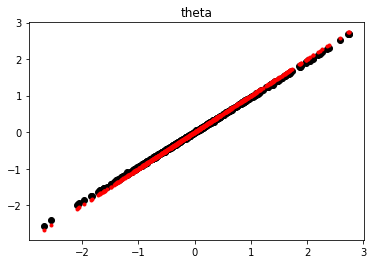

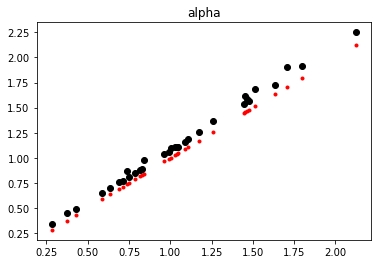

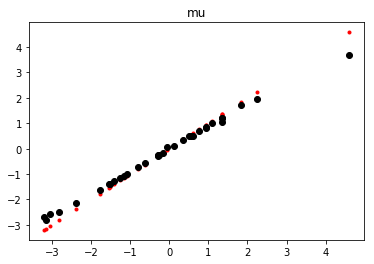

In [77]:
mcmc_theta = np.array(mcmc_df[ mcmc_df['par'].str.contains('theta') ]['mean'])
mcmc_alpha = np.array(mcmc_df[ mcmc_df['par'].str.contains('alpha') ]['mean'])
mcmc_beta = np.array(mcmc_df[ mcmc_df['par'].str.contains('beta') ]['mean'])

plt.figure()
plt.plot(mcmc_theta, model.vb_params['theta'].e(), 'ko')
plt.plot(mcmc_theta, mcmc_theta, 'r.')
plt.title('theta')

plt.figure()
plt.plot(mcmc_alpha, mcmc_alpha, 'r.')
plt.plot(mcmc_alpha, model.vb_params['log_alpha'].e_exp(), 'ko')
plt.title('alpha')

plt.figure()
plt.plot(mcmc_beta, mcmc_beta, 'r.')
plt.plot(mcmc_beta, model.vb_params['beta'].e(), 'ko')
plt.title('beta')

mcmc_mu = np.array(mcmc_df[ mcmc_df['par'].str.contains('mu') ]['mean'])
plt.plot(mcmc_mu, mcmc_mu, 'r.')
plt.plot(mcmc_mu, model.vb_params['mu'].e(), 'ko')
plt.title('mu')

e_sigma = model.vb_params['sigma_inv'].e_inv()
e_sigma_rescale = np.sqrt(np.diag(1 / np.diag(e_sigma)))
vb_omega = np.matmul(e_sigma_rescale, np.matmul(e_sigma, e_sigma_rescale))

print('Correlation matrices:')

# omega_11 = float(mcmc_df[ mcmc_df['par'] == 'Omega[1,1]' ]['mean'])
# omega_12 = float(mcmc_df[ mcmc_df['par'] == 'Omega[1,2]' ]['mean'])
# omega_22 = float(mcmc_df[ mcmc_df['par'] == 'Omega[2,2]' ]['mean'])
# omega = np.array([[omega_11, omega_12], [omega_12, omega_22]])

# print('mcmc:\n', omega)
# print('vb:\n', vb_omega)

# This doesn't seem right.
# tau_1 = float(mcmc_df[ mcmc_df['par'] == 'tau[1]' ]['mean'])
# tau_2 = float(mcmc_df[ mcmc_df['par'] == 'tau[2]' ]['mean'])

# print('Scales:')
# print('mcmc:\n', [ tau_1, tau_2 ])
# print('vb:\n', np.sqrt(np.diag(e_sigma)))